# ライブラリ

In [1]:
# ライブラリ
!pip install pulp
import pulp
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 14.2 MB 9.6 MB/s 


# 3.3 数理モデリングと実装

## データの確認

### 生徒データの確認

In [2]:
# データ読み込み
s_df = pd.read_csv("https://raw.githubusercontent.com/ohmsha/PyOptBook/main/3.school/students.csv")
s_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [3]:
# 行数
len(s_df)

318

In [4]:
# 学籍番号
s_df["student_id"]

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [5]:
# 学籍番号の最大値
s_df["student_id"].max()

318

In [6]:
# 学籍番号の最小値
s_df["student_id"].min()

1

In [7]:
# 1～318までの番号が使われていることを確認 
set(range(1, 319)) == set(s_df["student_id"].tolist())

True

In [8]:
# ユニークな番号の個数
len(s_df["student_id"].unique())

318

In [9]:
# 性別
s_df["gender"].value_counts()

0    160
1    158
Name: gender, dtype: int64

In [10]:
# 学力試験の点数
s_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

Text(0, 0.5, 'frequency')

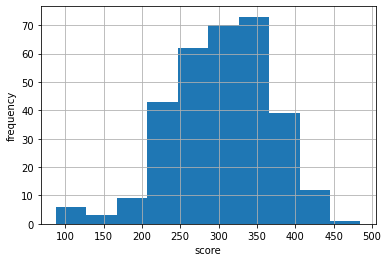

In [11]:
# 学力試験の点数のヒストグラム
s_df["score"].hist()
plt.xlabel("score")
plt.ylabel("frequency")

In [12]:
# リーダー気質フラグ
s_df["leader_flag"].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [13]:
# 特別支援フラグ
s_df["support_flag"].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

### 特定ペアデータの確認

In [14]:
# データ読み込み
s_pair_df = pd.read_csv("https://raw.githubusercontent.com/ohmsha/PyOptBook/main/3.school/student_pairs.csv")
s_pair_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


## 数理モデリングと実装

In [15]:
# 数理モデルのインスタンス作成
prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

In [16]:
# 生徒およびクラスのリスト
S = s_df["student_id"].tolist()
C = ["A", "B", "C", "D", "E", "F", "G", "H"]

# 生徒とクラスのペアのリスト
SC = [(s, c) for s in S for c in C]

In [17]:
# 変数を定義
x = pulp.LpVariable.dicts("x", SC, cat = "Binary")

In [18]:
# 要件(1) 各生徒は1つのクラスに割り当てる
for s in S:
  prob += pulp.lpSum([x[s, c] for c in C]) == 1

In [19]:
# 要件(2) 各クラスの生徒の人数は39人以上40人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S]) >= 39
  prob += pulp.lpSum([x[s, c] for s in S]) <= 40

In [20]:
# 生徒のリストを男子と女子に分ける
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

In [21]:
# 要件(3) 各クラスの男子生徒，女子生徒の人数は20人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
  prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

In [22]:
# 学力試験の点数を辞書表現に変換
score = {row.student_id: row.score for row in s_df.itertuples()}

# 学力試験の平均点
score_mean = s_df["score"].mean()

In [23]:
# 要件(4) 各クラスの学力試験の平均点は学年平均点±10点とする
for c in C:
  prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum([x[s, c] * score[s] for s in S])
  prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

In [24]:
# リーダー気質の生徒のリスト
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

In [25]:
# 要件(5) 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

In [26]:
# 特別な支援が必要な生徒のリスト
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

In [27]:
# 要件(6) 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

In [28]:
# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

In [29]:
# 要件(7) 特定ペアの生徒は同一クラスに割り当てない
for s1, s2 in SS:
  for c in C:
    prob += x[s1, c] + x[s2, c] <= 1

In [30]:
# 問題を解く
status = prob.solve()
print(pulp.LpStatus[status])

Optimal


In [31]:
# 各クラスに割り当てられた生徒のリストを辞書に格納
C2Ss = {}
for c in C:
  C2Ss[c] = [s for s in S if x[s, c].value() == 1]

# 最適化結果の表示
for c, Ss in C2Ss.items():
  print(f"Class: {c}")
  print(f"Num: {len(Ss)}")
  print(f"Student: {Ss}\n")

Class: A
Num: 40
Student: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 237, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 40
Student: [11, 15, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 124, 127, 146, 149, 159, 167, 170, 172, 176, 188, 190, 203, 212, 213, 220, 222, 231, 238, 245, 263, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Student: [3, 10, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 122, 142, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 277, 278, 301, 318]

Class: D
Num: 40
Student: [13, 16, 36, 37, 43, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 121, 128, 134, 139, 140, 158, 161, 175, 192, 198, 200, 205, 218, 221, 225, 235, 241, 252, 255, 256, 257, 261, 266, 293, 316]

Class: E
Num: 40
Student: [5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 107, 115, 129, 132, 141, 143, 150, 154, 164, 166, 183, 184, 189, 19

# 3.4 数理モデルの検証

## 解が要件を満たしているかどうか確認

In [36]:
# 要件(1) 学年の全生徒をそれぞれ1つのクラスに割り当てる
for s in S:

  # 生徒sが割り当てられたクラスを取得
  assigned_class = [x[s, c].value() for c in C if x[s, c].value() == 1]

  # 1つのクラスに割り当てられているか確認
  if len(assigned_class) != 1:
    print("Error:", s, assigned_class)

In [40]:
# 検証用データフレーム
result_df = s_df.copy()
result_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [39]:
# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {s: c for s in S for c in C if x[s, c].value() == 1}

In [41]:
# 生徒データに各生徒がどのクラスに割り当てられたかの情報を結合
result_df["assigned_class"] = result_df["student_id"].map(S2C)
result_df.head()

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,F
1,2,1,0,0,379,A
2,3,0,0,0,350,C
3,4,0,0,0,301,G
4,5,1,0,0,317,E


In [46]:
# 要件(2) 各クラスの生徒の人数は39人以上，40人以下とする
result_df.groupby("assigned_class")["student_id"].count()

assigned_class
A    40
B    40
C    40
D    40
E    40
F    39
G    40
H    39
Name: student_id, dtype: int64

In [47]:
# 要件(3) 各クラスの男子生徒，女子生徒の人数は20人以下とする
result_df.groupby(["assigned_class", "gender"])["student_id"].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         19
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [51]:
# 要件(4) 各クラスの学力試験の平均点は学年平均点±10点とする
result_df.groupby("assigned_class")["score"].mean() - result_df["score"].mean()

assigned_class
A    9.755346
B   -9.169654
C    8.355346
D    6.855346
E   -6.869654
F   -8.260039
G    8.605346
H   -9.721577
Name: score, dtype: float64

In [52]:
# 要件(5) 各クラスにリーダー気質の生徒を2人以上割り当てる
result_df.groupby("assigned_class")["leader_flag"].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [53]:
# 要件(6) 特別な支援が必要な生徒は各クラスに1人以下とする
result_df.groupby("assigned_class")["support_flag"].sum()

assigned_class
A    0
B    1
C    1
D    0
E    1
F    0
G    1
H    0
Name: support_flag, dtype: int64

In [59]:
# 要件(7) 特定ペアの生徒は同一クラスに割り当てない
for i, (s1, s2) in enumerate(SS):
  print(f"Case: {i}")
  c1 = S2C[s1]
  c2 = S2C[s2]
  print("s1: {} - {}".format(s1, c1))
  print("s2: {} - {}".format(s2, c2))
  print("")

Case: 0
s1: 118 - G
s2: 189 - E

Case: 1
s1: 72 - E
s2: 50 - B

Case: 2
s1: 314 - H
s2: 233 - A



## 設定した制約の見直しと課題の洗い出し

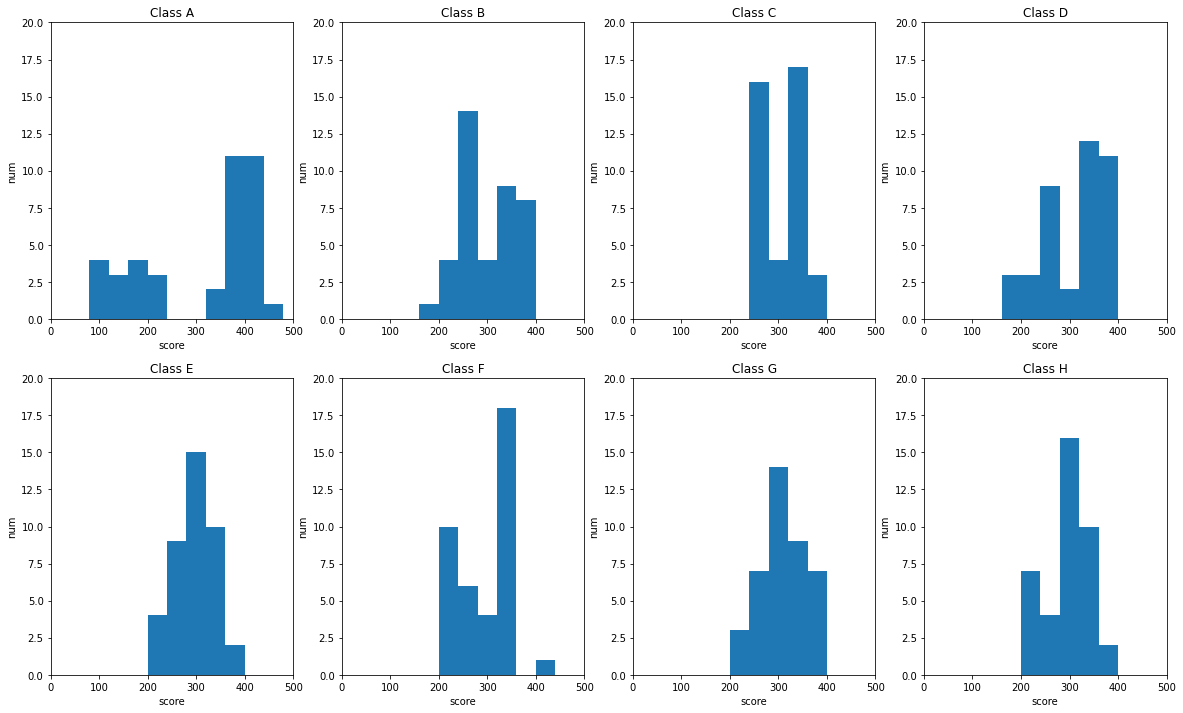

In [70]:
# クラス別学力試験の分布
fig = plt.figure(figsize = (20, 12))
for i, c in enumerate(C):
  cls_df = result_df[result_df["assigned_class"] == c]
  ax = fig.add_subplot(2, 4, i+1, xlabel = "score", ylabel = "num", xlim = (0, 500), ylim = (0, 20), title = "Class {}".format(c))
  ax.hist(cls_df["score"], bins = range(0, 500, 40))

## 制約の改善と数理最適化モデルの修正

In [71]:
# 初期クラス編成データを作成

# 学力をもとに順位を付与
s_df["score_rank"] = s_df["score"].rank(ascending = False, method = "first")
s_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank
0,1,0,0,0,335,109.0
1,2,1,0,0,379,38.0
2,3,0,0,0,350,79.0
3,4,0,0,0,301,172.0
4,5,1,0,0,317,147.0


In [72]:
# 学力順にクラス編成し，init_assigned_classカラムを作成
class_dic = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H"}
s_df["init_assigned_class"] = s_df["score_rank"].map(lambda x: x % 8).map(class_dic)
s_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D


In [76]:
# 初期クラス編成フラグを作成
init_flag = {(s, c): 0 for s in S for c in C}
for row in s_df.itertuples():
  init_flag[row.student_id, row.init_assigned_class] = 1

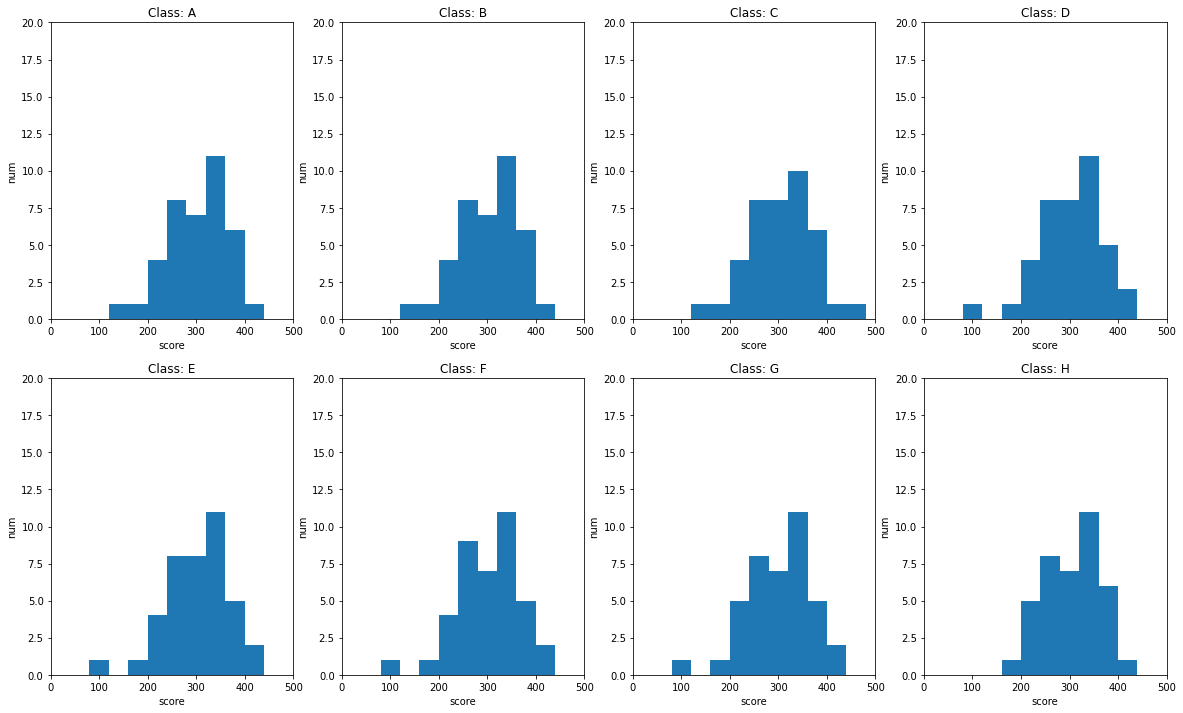

In [77]:
# 初期クラス編成における各クラスの学力分布
fig = plt.figure(figsize = (20, 12))
for i, c in enumerate(C):
  cls_df = s_df[s_df["init_assigned_class"] == c]
  ax = fig.add_subplot(2, 4, i+1, xlabel = "score", ylabel = "num", xlim = (0, 500), ylim = (0, 20), title = "Class: {}".format(c))
  ax.hist(cls_df["score"], bins = range(0, 500, 40))

In [79]:
# 数理モデルに目的関数（初期クラス編成とできるだけ一致させる）を追加
prob += pulp.lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

In [80]:
# モデルを再度定義し，最適化を実行

# 数理モデルのインスタンス作成
prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

# 変数を定義
x = pulp.LpVariable.dicts("x", SC, cat = "Binary")

# 要件(1) 各生徒は1つのクラスに割り当てる
for s in S:
  prob += pulp.lpSum([x[s, c] for c in C]) == 1

# 要件(2) 各クラスの生徒の人数は39人以上40人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S]) >= 39
  prob += pulp.lpSum([x[s, c] for s in S]) <= 40

# 要件(3) 各クラスの男子生徒，女子生徒の人数は20人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
  prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

# 要件(4) 各クラスの学力試験の平均点は学年平均点±10点とする
for c in C:
  prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum([x[s, c] * score[s] for s in S])
  prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

# 要件(5) 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

# 要件(6) 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
  prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

# 要件(7) 特定ペアの生徒は同一クラスに割り当てない
for s1, s2 in SS:
  for c in C:
    prob += x[s1, c] + x[s2, c] <= 1

# 目的関数（初期クラス編成とできるだけ一致させる）
prob += pulp.lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

In [82]:
# 問題を解く
status = prob.solve()
print("Status:", pulp.LpStatus[status])

Status: Optimal


In [83]:
# 各クラスに割り当てられた生徒のリストを辞書に格納
C2Ss = {}
for c in C:
  C2Ss[c] = [s for s in S if x[s, c].value() == 1]

# 最適化結果の表示
for c, Ss in C2Ss.items():
  print(f"Class: {c}")
  print(f"Num: {len(Ss)}")
  print(f"Student: {Ss}\n")

Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203, 234, 235, 240,

In [84]:
# 検証用データフレーム作成
result_df2 = s_df.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {s:c for s in S for c in C if x[s, c].value() == 1}

# 生徒データにS2Cを結合
result_df2["assigned_class"] = result_df2["student_id"].map(S2C)
result_df2.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D


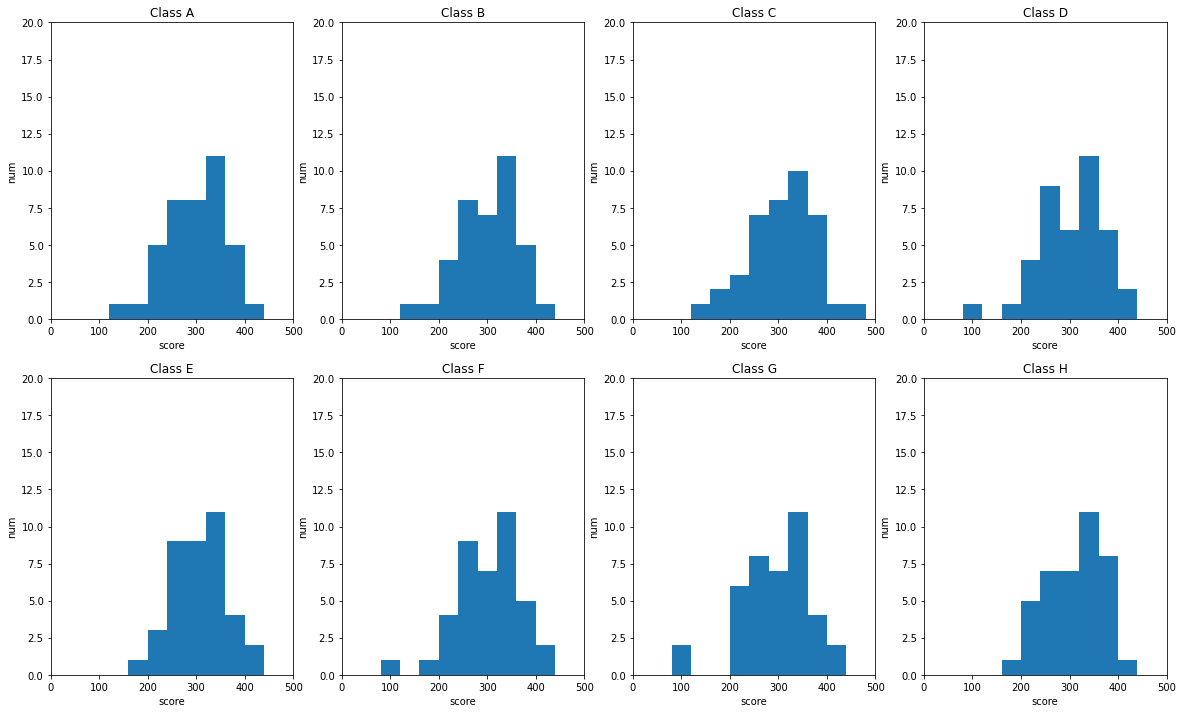

In [86]:
# 各クラスの学力の分布を確認
fig = plt.figure(figsize = (20, 12))
for i, c in enumerate(C):
  cls_df = result_df2[result_df2["assigned_class"] == c]
  ax = fig.add_subplot(2, 4, i+1, xlabel = "score", ylabel = "num", xlim = (0, 500), ylim = (0, 20), title = "Class {}".format(c))
  ax.hist(cls_df["score"], bins = range(0, 500, 40))